In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

from chiseling.dgps.benchtm import BenchTM
from chiseling.source.protocol.utils import aipw_intercept_pseudo_outcome

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import RidgeCV

In [3]:
# Hyperparameters
n = 500

alpha = 0.05

random_seed = 3

benchtm_path = "../../../benchtm/"

In [4]:
np.random.seed(random_seed)

In [5]:
# Sample data
sampler = BenchTM(scenario=5, benchtm_path=benchtm_path, random_seed=random_seed)

In [6]:
samp_inds = np.random.choice(sampler.benchtm_df.shape[0], n, replace=True)

In [7]:
trt_effect = sampler.benchtm_df["trt_effect"].iloc[samp_inds].values
T = sampler.T[samp_inds]
X = sampler.X[samp_inds]
Y = sampler.Y[samp_inds]

In [8]:
k = 50
# k = 250
k_remain = n - k

In [9]:
T_train, X_train, Y_train = T[:k], X[:k], Y[:k]
pY_train = aipw_intercept_pseudo_outcome(T_train, X_train, Y_train)
trt_effect_train = trt_effect[:k]

In [10]:
rf1 = RandomForestRegressor(random_state=random_seed,
                            oob_score=True,
                            ccp_alpha=1).fit(X_train[T_train==1], Y_train[T_train==1])
rf0 = RandomForestRegressor(random_state=random_seed,
                            oob_score=True,
                            ccp_alpha=1).fit(X_train[T_train==0], Y_train[T_train==0])

In [11]:
preds_1 = rf1.predict(X_train)
preds_0 = rf0.predict(X_train)
preds = preds_1 - preds_0
# per_tree_preds_1 = np.stack([tree.predict(X_train) for tree in rf1.estimators_])
# per_tree_preds_0 = np.stack([tree.predict(X_train) for tree in rf0.estimators_])
# n_trees = per_tree_preds_1.shape[0]
# per_tree_preds_1_var = per_tree_preds_1.var(axis=0)
# per_tree_preds_0_var = per_tree_preds_0.var(axis=0)
# pred_ses = np.sqrt(per_tree_preds_1_var / n_trees + per_tree_preds_0_var / n_trees)

In [12]:
oob_preds_1 = np.zeros(Y_train.shape[0])
oob_preds_0 = np.zeros(Y_train.shape[0])
oob_preds_1[T_train==1] = rf1.oob_prediction_
oob_preds_1[T_train==0] = preds_1[T_train==0]
oob_preds_0[T_train==0] = rf0.oob_prediction_
oob_preds_0[T_train==1] = preds_0[T_train==1]

oob_preds = oob_preds_1 - oob_preds_0

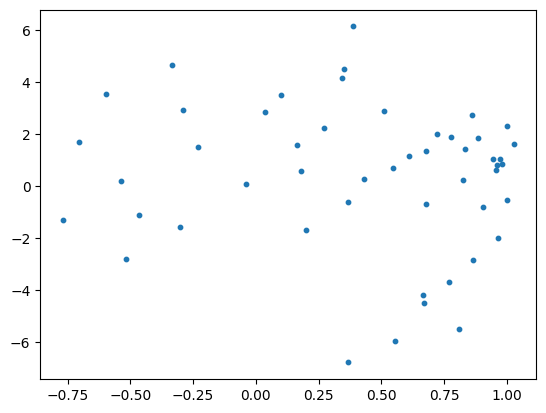

PearsonRResult(statistic=np.float64(-0.12336812798976857), pvalue=np.float64(0.3933556867375765))


In [13]:
plt.scatter(oob_preds, pY_train, s=10)
plt.show()
print(scipy.stats.pearsonr(oob_preds, pY_train))

In [14]:
pY_train.mean()

np.float64(0.37138933203196944)

In [15]:
# boot_ids = np.random.choice(len(oob_preds), len(oob_preds), replace=True)
boot_ids = np.arange(len(oob_preds))

# scores = oob_preds[boot_ids]
outcomes = pY_train[boot_ids]
scores = preds[boot_ids]

In [16]:
# Construct the range for the grid
thresh_space = np.linspace(scores.min()-0.1, scores.max()+0.1, 100)
# Calculate the empirical means, standard deviations, and proportions
all_subgroup_means = []
all_subgroup_stds = []
all_subgroup_props = []
sub_thresh_space = []
for thresh in thresh_space:
    subgroup_inds = (scores > thresh)
    subgroup_size = subgroup_inds.sum()
    if subgroup_size < 10:
        break
    subgroup_mean = outcomes[subgroup_inds].mean()
    subgroup_std = outcomes[subgroup_inds].std()
    subgroup_prop = subgroup_inds.mean()
    all_subgroup_means.append(subgroup_mean)
    all_subgroup_stds.append(subgroup_std)
    all_subgroup_props.append(subgroup_prop)
    sub_thresh_space.append(thresh)
all_subgroup_means = np.array(all_subgroup_means)
all_subgroup_stds = np.array(all_subgroup_stds)
all_subgroup_props = np.array(all_subgroup_props)
sub_thresh_space = np.array(sub_thresh_space)

In [17]:
# all_subgroup_means = np.maximum(0, all_subgroup_means)

In [18]:
iso_subgroup_means = IsotonicRegression(increasing=True).fit_transform(sub_thresh_space,
                                                                       all_subgroup_means)
iso_subgroup_stds = IsotonicRegression(increasing=False).fit_transform(sub_thresh_space,
                                                                       all_subgroup_stds)

In [19]:
all_subgroup_t = np.sqrt(all_subgroup_props * k_remain) * all_subgroup_means / all_subgroup_stds
iso_subgroup_t = np.sqrt(all_subgroup_props * k_remain) * iso_subgroup_means / iso_subgroup_stds

est_utility = all_subgroup_means * all_subgroup_props
est_power = scipy.stats.norm.cdf(all_subgroup_t - scipy.stats.norm.ppf(1 - alpha))
est_exp_utility = est_utility * est_power

est_iso_utility = iso_subgroup_means * all_subgroup_props
est_iso_power = scipy.stats.norm.cdf(iso_subgroup_t - scipy.stats.norm.ppf(1 - alpha))
est_iso_exp_utility = est_iso_utility * est_iso_power

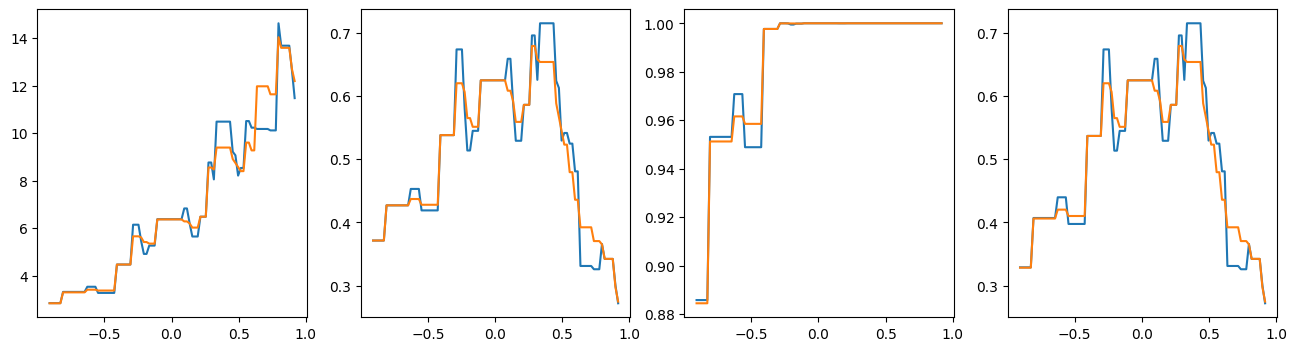

In [20]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

ax[0].plot(sub_thresh_space, all_subgroup_t)
ax[0].plot(sub_thresh_space, iso_subgroup_t)

ax[1].plot(sub_thresh_space, est_utility)
ax[1].plot(sub_thresh_space, est_iso_utility)

ax[2].plot(sub_thresh_space, est_power)
ax[2].plot(sub_thresh_space, est_iso_power)

ax[3].plot(sub_thresh_space, est_exp_utility)
ax[3].plot(sub_thresh_space, est_iso_exp_utility)

plt.show()

In [21]:
# best_thresh = sub_thresh_space[np.argmax(est_iso_exp_utility)]
best_thresh = sub_thresh_space[np.argmax(est_exp_utility)]
print(best_thresh)

0.33517465771914556


In [22]:
# (((preds + 3 * pred_ses) <= best_thresh).mean(),
#  ((preds + 2 * pred_ses) <= best_thresh).mean(),
#  ((preds + 1 * pred_ses) <= best_thresh).mean(),
#  (preds <= best_thresh).mean())

In [23]:
shift = 0

In [24]:
(preds <= best_thresh).mean(), trt_effect_train[preds <= best_thresh - shift].mean()

(np.float64(0.4), np.float64(-0.04645634583947791))

In [25]:
all_preds_1 = rf1.predict(X)
all_preds_0 = rf0.predict(X)
all_preds = all_preds_1 - all_preds_0
# per_tree_preds_1 = np.stack([tree.predict(X) for tree in rf1.estimators_])
# per_tree_preds_0 = np.stack([tree.predict(X) for tree in rf0.estimators_])
# n_trees = per_tree_preds_1.shape[0]
# per_tree_preds_1_var = per_tree_preds_1.var(axis=0)
# per_tree_preds_0_var = per_tree_preds_0.var(axis=0)
# pred_ses = np.sqrt(per_tree_preds_1_var / n_trees + per_tree_preds_0_var / n_trees)

In [26]:
print((all_preds[k:] > best_thresh - shift).mean())
print(trt_effect[k:][all_preds[k:] > best_thresh - shift].mean())
print(trt_effect[k:][all_preds[k:] > best_thresh - shift].std())

0.6311111111111111
0.40228374160366265
0.29206790533478455


In [27]:
print(trt_effect.mean(), trt_effect[k:].mean())
print(trt_effect.std(), trt_effect[k:].std())

0.2245953675357302 0.21883634348402634
0.3392788318279077 0.33763107532043213


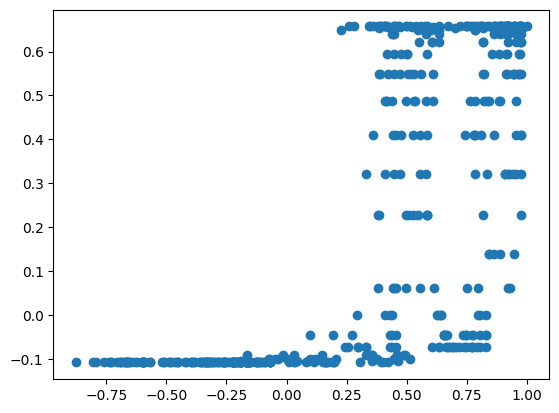

In [28]:
plt.scatter(all_preds, trt_effect)
plt.show()

In [29]:
scipy.stats.pearsonr(all_preds, trt_effect)

PearsonRResult(statistic=np.float64(0.7207053289458093), pvalue=np.float64(2.8514698440019144e-81))

In [30]:
alphas = np.logspace(-5,5,30)
reg1 = RidgeCV(alphas=alphas).fit(X_train[T_train==1], Y_train[T_train==1])
reg0 = RidgeCV(alphas=alphas).fit(X_train[T_train==0], Y_train[T_train==0])

In [31]:
all_preds_1 = reg1.predict(X)
all_preds_0 = reg0.predict(X)
all_preds = all_preds_1 - all_preds_0

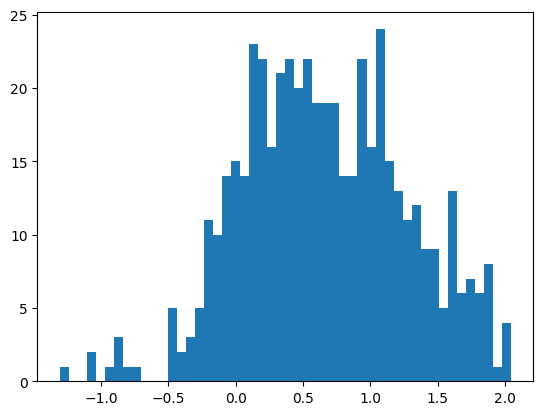

In [32]:
plt.hist(all_preds, bins=50)
plt.show()

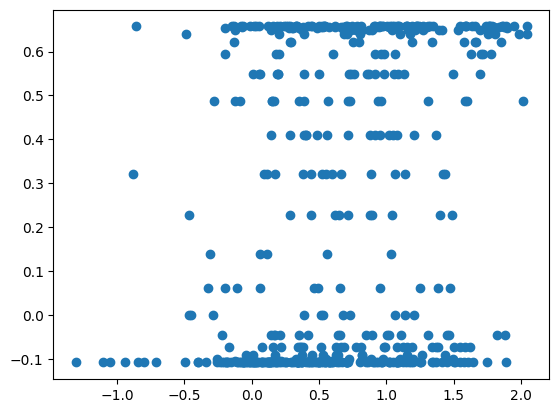

In [33]:
plt.scatter(all_preds, trt_effect)
plt.show()

In [34]:
scipy.stats.pearsonr(all_preds, trt_effect)

PearsonRResult(statistic=np.float64(0.2612145685155848), pvalue=np.float64(3.037260268760536e-09))

### Something else

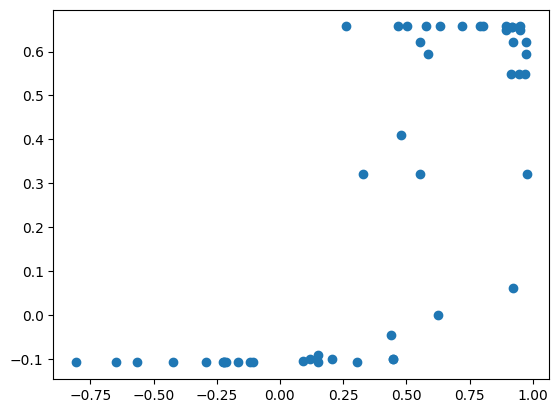

In [43]:
plt.scatter(preds, trt_effect_train)
plt.show()

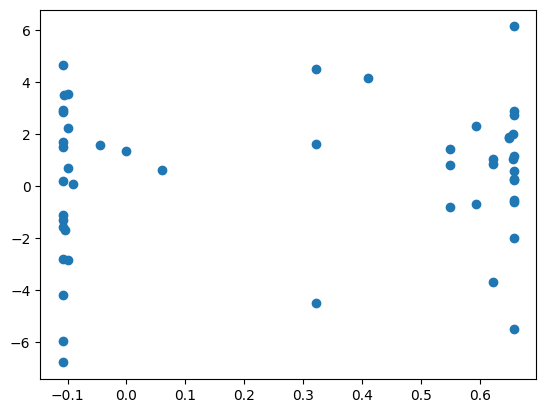

In [44]:
plt.scatter(trt_effect_train, pY_train)
plt.show()

In [35]:
# Some thoughts:
# Repeated data splitting to get a less biased estimate of the utility curve
# Leverage confidence and continuous allocation somehow?
# If all effects = constant, then technically we may learn that it's OK to threshold a high score?
# Or we really shouldn't right...?
# Direct greedy splitting to optimize utility? Like in the Spiess paper, make that the objective?
# Use X-learner
# Try a well-specified, large sample size, small signal size setting to see how things fare?
# Write a script to test power for 50/50 data splitting variant of this (compared to thresh at 0)

In [36]:
# What if we scored every unit by strata conditional expected utility as an approximation?
# What if we made use of an assumption that we have a calibrated predictor?